In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import polars as pl
import tabulate as tb

from fart.common.constants import (
    BBANDS_LOWER,
    BBANDS_MIDDLE,
    BBANDS_UPPER,
    BUY,
    CLOSE,
    DATETIME,
    EMA_FAST,
    EMA_SLOW,
    HONOLULU_BLUE,
    PROCEEDS,
    SELL,
    TOTAL_RETURN,
    TRADE_SIGNAL,
)
from fart.features.calculate_technical_indicators import calculate_technical_indicators
from fart.features.parse_timestamp_to_datetime import parse_timestamp_to_datetime
from fart.features.trade_strategy import TradeStrategy
from fart.visualization.candlestick_chart import CandlestickChart

In [2]:
# Load data
df = pl.read_csv("../data/BTC-EUR.csv")

In [3]:
# Convert timestamp to datetime
df = parse_timestamp_to_datetime(df)

In [4]:
# Calculate technical indicators:
# - Bollinger Bands
# - Exponential Moving Average,
# - Moving Average Convergence Divergence
# - Relative Strength Index
df = calculate_technical_indicators(df)

df.head()

Timestamp,Open,High,Low,Close,Volume,Datetime,Bollinger Bands: Upper,Bollinger Bands: Middle,Bollinger Bands: Lower,Exponential Moving Average: Fast,Exponential Moving Average: Slow,Moving Average Convergence Divergence,Moving Average Convergence Divergence: Signal,Moving Average Convergence Divergence: Histogram,Relative Strength Index
i64,f64,f64,f64,f64,f64,datetime[ms],f64,f64,f64,f64,f64,f64,f64,f64,f64
1552032000000,3456.2,3456.2,3456.2,3456.2,0.03012,2019-03-08 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552041000000,3461.0,3464.9,3461.0,3464.9,0.114394,2019-03-08 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552042800000,3461.1,3463.3,3461.1,3463.3,0.068582,2019-03-08 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552044600000,3461.2,3461.2,3460.7,3460.7,0.10072,2019-03-08 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1552046400000,3459.1,3463.0,3453.4,3463.0,1.9856248,2019-03-08 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


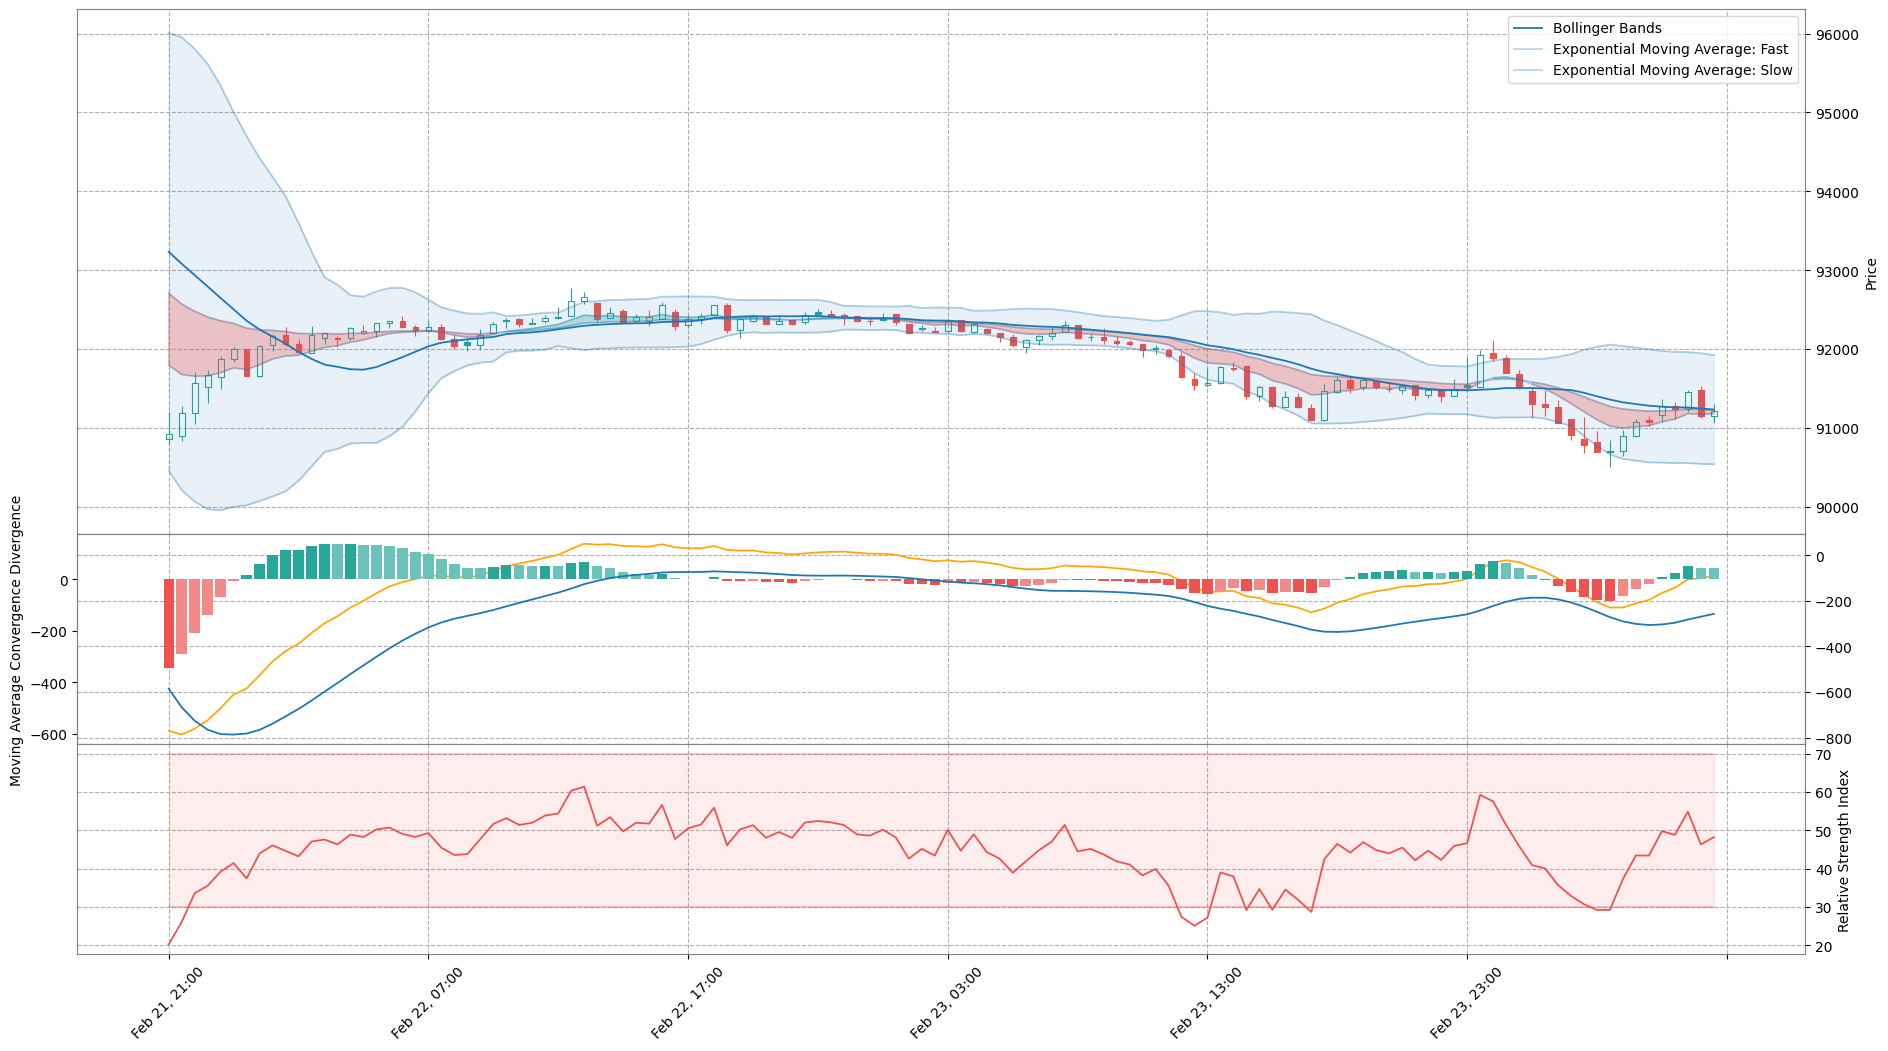

In [5]:
# Plot last 120 entries in candlestick chart
CandlestickChart(df.to_pandas().set_index(DATETIME)).plot()

In [6]:
df = df.with_columns(
    pl.when(pl.col(CLOSE).shift(-1) - pl.col(CLOSE) > 0)
    .then(pl.lit(BUY))
    .otherwise(pl.lit(SELL))
    .alias(TRADE_SIGNAL)
)

In [7]:
df[TRADE_SIGNAL].value_counts()

Trade Signal,count
str,u32
"""Buy""",52202
"""Sell""",51358


In [8]:
trade_strategy = TradeStrategy(df, transaction_cost=0.0025)
trade_strategy.backtest()

results = [
    ["Initial Capital (€)", trade_strategy.initial_capital],
    tb.SEPARATING_LINE,
    ["No. Trades", len(trade_strategy.trades)],
    tb.SEPARATING_LINE,
    [f"{PROCEEDS} (€)", round(trade_strategy.proceeds, 2)],
    [f"{TOTAL_RETURN} (%)", round(trade_strategy.total_return * 100, 2)],
]

print(tb.tabulate(results))

-------------------  ---------------
Initial Capital (€)    500
-------------------  ---------------
No. Trades           55448
-------------------  ---------------
Proceeds (€)             6.75663e+41
Total Return (%)         1.35133e+41
-------------------  ---------------


In [9]:
BBANDS_LOWER_DETREND = f"{CLOSE} - {BBANDS_LOWER}"
BBANDS_MIDDLE_DETREND = f"{CLOSE} - {BBANDS_MIDDLE}"
BBBANDS_UPPER_DETREND = f"{CLOSE} - {BBANDS_UPPER}"
EMA_FAST_DETREND = f"{CLOSE} - {EMA_FAST}"
EMA_SLOW_DETREND = f"{CLOSE} - {EMA_SLOW}"

df = df.with_columns(
    (pl.col(CLOSE) - pl.col(BBANDS_LOWER)).alias(BBANDS_LOWER_DETREND),
    (pl.col(CLOSE) - pl.col(BBANDS_MIDDLE)).alias(BBANDS_MIDDLE_DETREND),
    (pl.col(CLOSE) - pl.col(BBANDS_UPPER)).alias(BBBANDS_UPPER_DETREND),
    (pl.col(CLOSE) - pl.col(EMA_FAST)).alias(EMA_FAST_DETREND),
    (pl.col(CLOSE) - pl.col(EMA_SLOW)).alias(EMA_SLOW_DETREND),
)

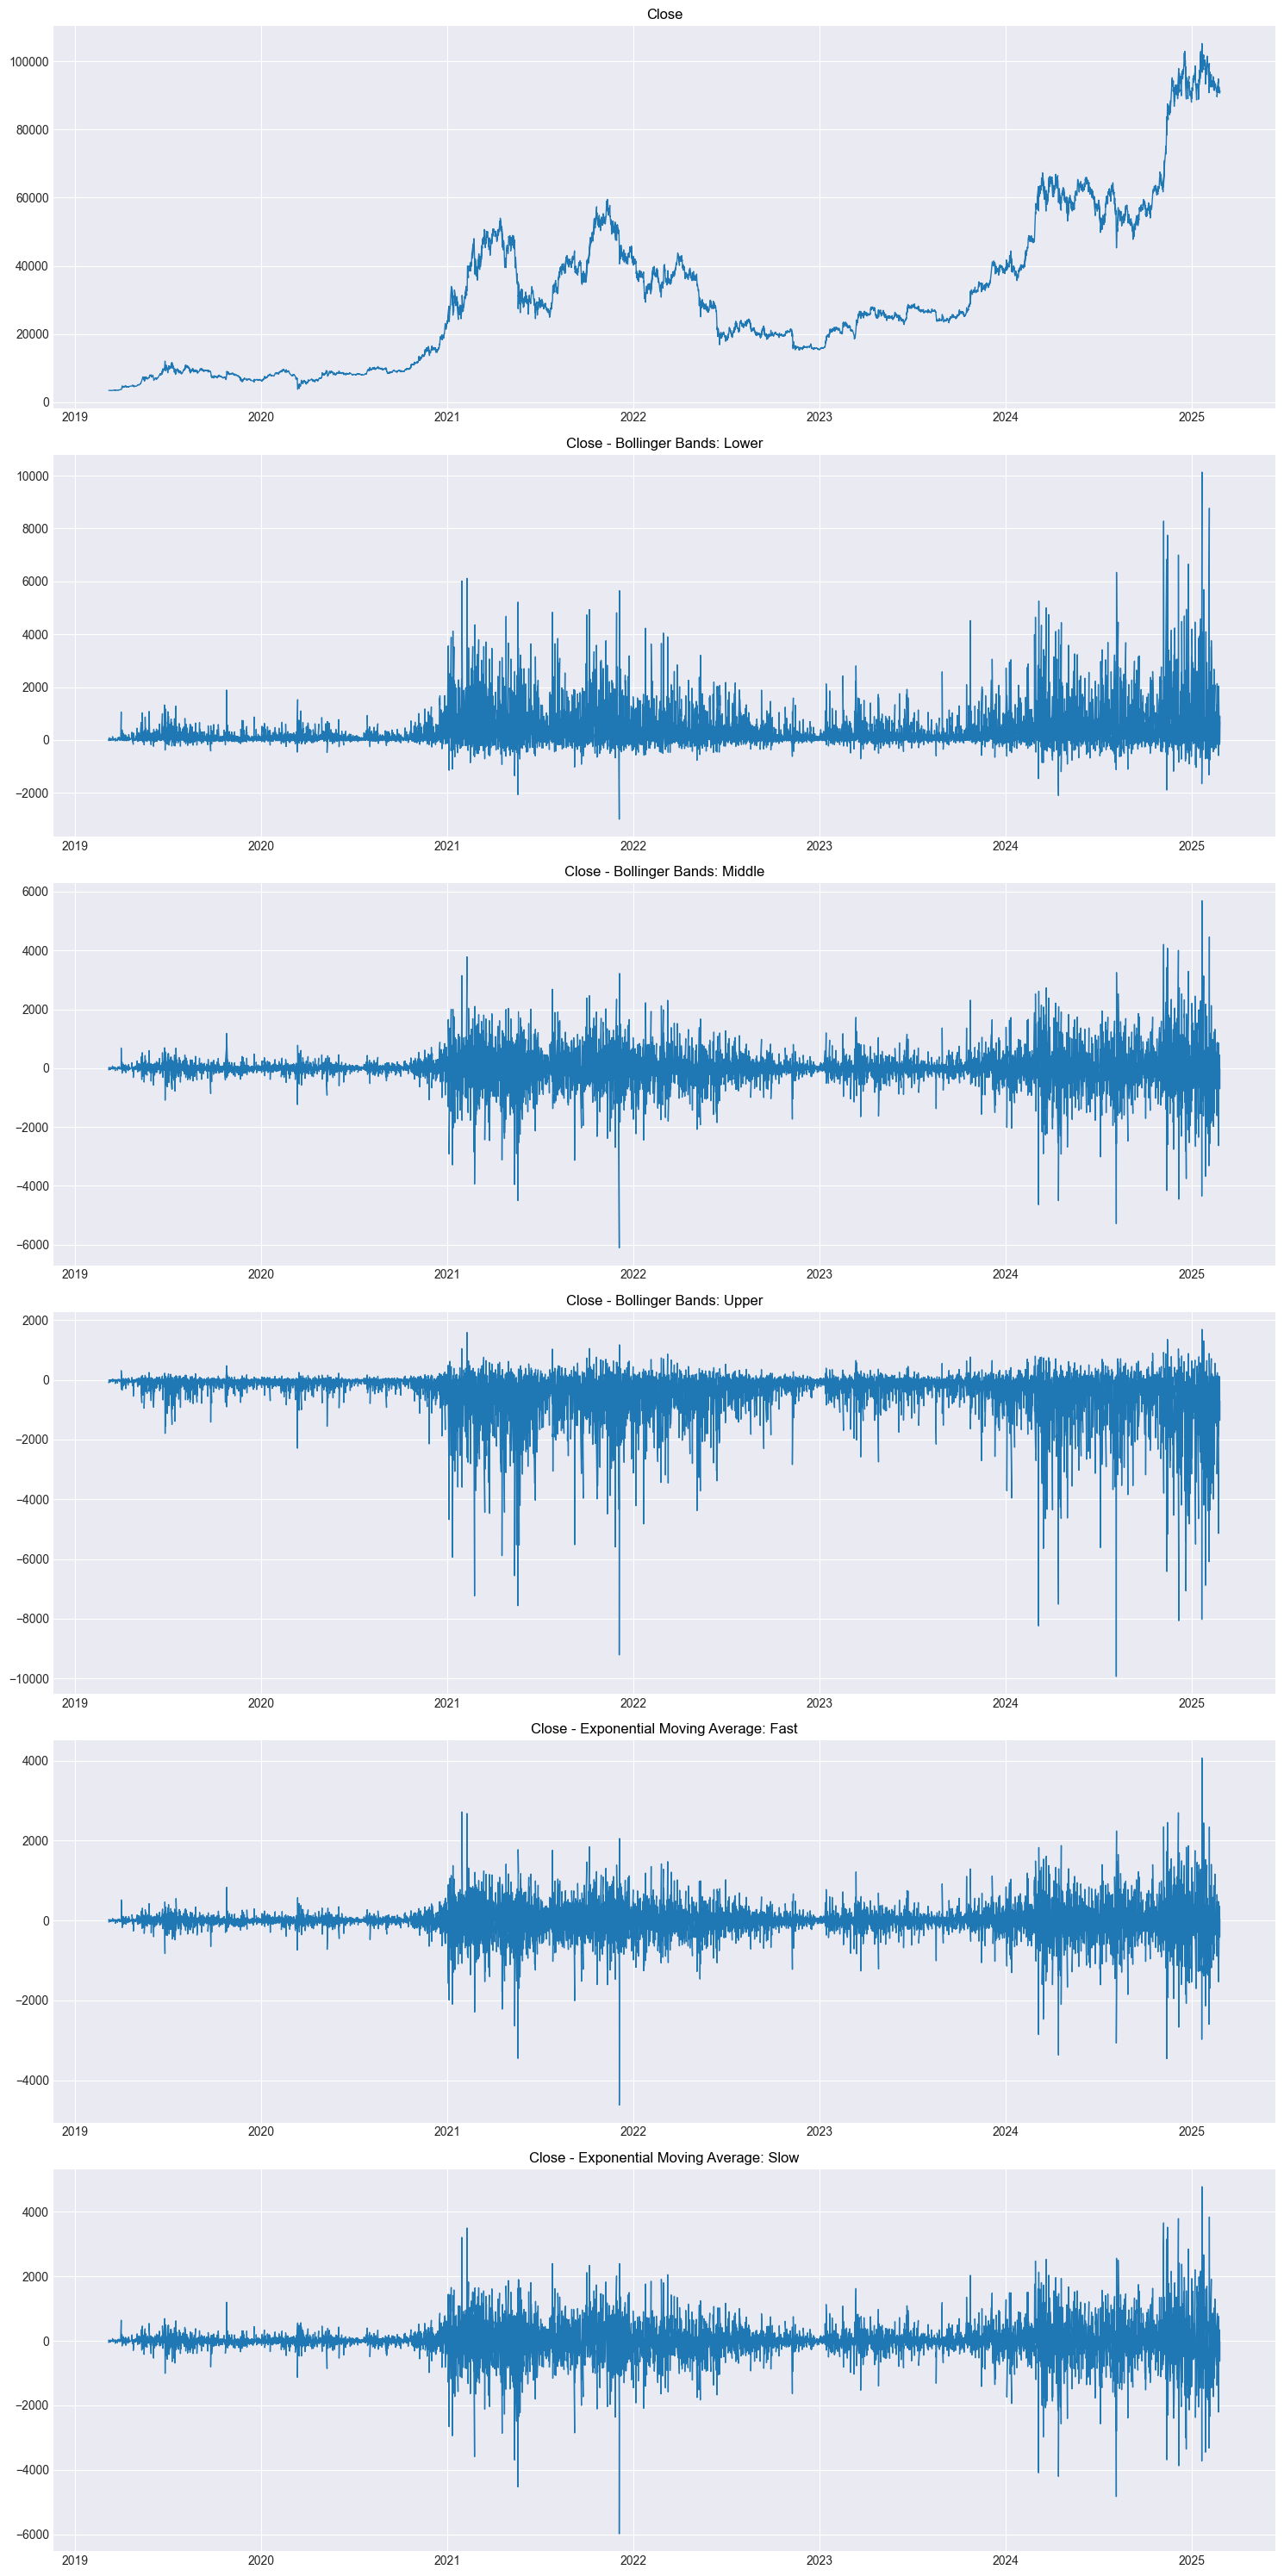

In [10]:
plt.style.use("seaborn-v0_8-darkgrid")

_, axes = plt.subplots(6, 1, figsize=(15, 30))

features = [
    CLOSE,
    BBANDS_LOWER_DETREND,
    BBANDS_MIDDLE_DETREND,
    BBBANDS_UPPER_DETREND,
    EMA_FAST_DETREND,
    EMA_SLOW_DETREND,
]

for ax, feature in zip(axes, features):
    ax.plot(df[DATETIME], df[feature], linewidth="1", color=HONOLULU_BLUE)
    ax.set_title(feature, color="black")

plt.tight_layout()
plt.show()


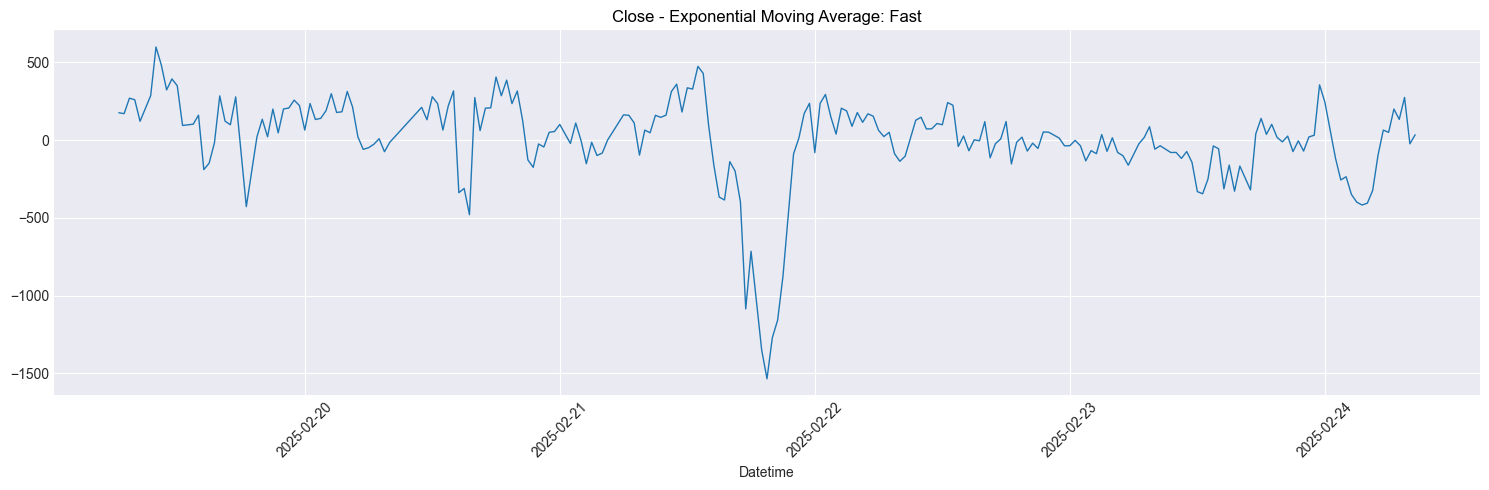

In [11]:
plt.style.use("seaborn-v0_8-darkgrid")

subset = df[-240:]

plt.figure(figsize=(15, 5))
plt.xlabel(DATETIME)
plt.xticks(rotation=45)
plt.title(EMA_FAST_DETREND, color="black")
plt.plot(subset[DATETIME], subset[EMA_FAST_DETREND], linewidth="1", color=HONOLULU_BLUE)

plt.tight_layout()
plt.show()
